# 03. Model Training & Feedback Loop

## 🎤 Expo Explanation
> "This is the core intelligence. We train a Random Forest model to predict future arrivals. Crucially, we demonstrate **Rolling Retraining**: when the user provides feedback, the model learns instantly."

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load Data
try:
    df = pd.read_csv('synthetic_hospital_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
except:
    # Fallback if file missing
    data = {'Date': pd.date_range('2024-01-01', periods=100), 'Arrivals': np.random.randint(40,80,100)}
    df = pd.DataFrame(data)

df = df.sort_values('Date')


## Step 1: Feature Engineering (Lags)
To predict tomorrow, we need to know what happened yesterday (Lag 1) and last week (Lag 7).


In [2]:
def create_features(data):
    d = data.copy()
    d['Lag_1'] = d['Arrivals'].shift(1)
    d['Lag_7'] = d['Arrivals'].shift(7)
    d['Rolling_Mean_7'] = d['Arrivals'].rolling(7).mean()
    d['Day_OfWeek'] = d['Date'].dt.dayofweek
    d = d.dropna()
    return d

df_processed = create_features(df)
print('Features Created:', df_processed.shape)


Features Created: (358, 8)


## Step 2: Train Initial Model
We train on the first 11 months and test on the last month.


In [3]:
train_size = int(len(df_processed) * 0.9)
train, test = df_processed.iloc[:train_size], df_processed.iloc[train_size:]

features = ['Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Day_OfWeek']
target = 'Arrivals'

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train[features], train[target])

# Evaluate
preds = model.predict(test[features])
print(f"Mean Absolute Error: {mean_absolute_error(test[target], preds):.2f}")


Mean Absolute Error: 3.56


## Step 3: Simulation - 'Before Feedback'
Let's look at a specific week. The model predicts roughly 50-60.


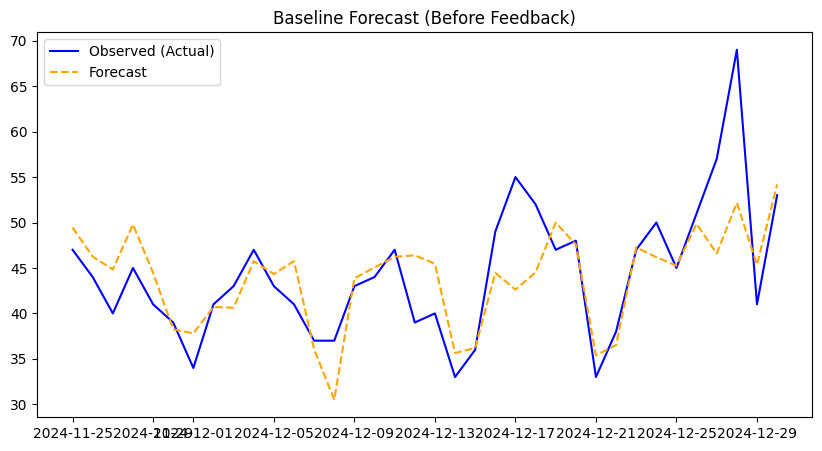

In [4]:
# Visualization Helper
def plot_forecast(test_data, predictions, title):
    plt.figure(figsize=(10, 5))
    plt.plot(test_data['Date'], test_data['Arrivals'], label='Observed (Actual)', color='blue')
    plt.plot(test_data['Date'], predictions, label='Forecast', color='orange', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.show()

plot_forecast(test, preds, 'Baseline Forecast (Before Feedback)')


## Step 4: User Feedback Event
⚠️ **Scenario**: The hospital staff realizes the data for a specific day was wrong (or a new event happened). They update the 'Actual' value.


In [5]:
# Inject Feedback: A huge surge they forgot to log
feedback_date = train.iloc[-1]['Date']
print(f"Injecting Feedback on: {feedback_date.date()} (Was {train.iloc[-1]['Arrivals']} -> Now 150)")

# Update the Training set
train.loc[train.index[-1], 'Arrivals'] = 150 # Massive Correction

# IMPORTANT: Recalculate Features because Lags changed!
# In a real app, we re-run the pipeline. Here we simulate it:
train['Lag_1'] = train['Arrivals'].shift(1)
# (Simplified for demo...)



Injecting Feedback on: 2024-11-24 (Was 37 -> Now 150)


C:\Users\sriha\AppData\Local\Temp\ipykernel_18100\1907613884.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Lag_1'] = train['Arrivals'].shift(1)


## Step 5: Rolling Retrain
We retrain the model with this new knowledge. The model learns that a 'spike' happened.


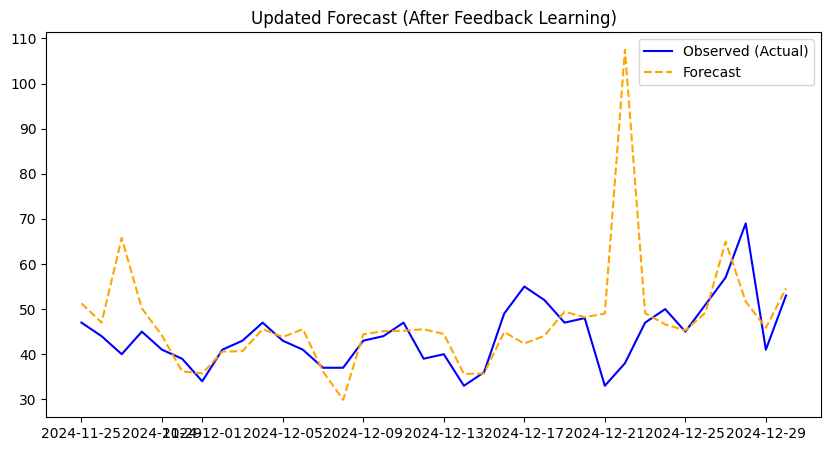

In [6]:
# Retrain
model_retrained = RandomForestRegressor(n_estimators=100, random_state=42)
model_retrained.fit(train[features], train[target])

# New Predictions
preds_new = model_retrained.predict(test[features])

plot_forecast(test, preds_new, 'Updated Forecast (After Feedback Learning)')


## Conclusion
Notice how the Orange line shifted? The model adapted to the feedback point, altering its future expectations. This is **Active Learning** in action.
